RFM, LTV and Segmentation with Classification Algorithm

In [2]:
import pandas as pd
import numpy as np

In [9]:
#import
an = pd.read_excel (r'C:\Users\ozguome\Desktop/Case Studies/Case Study ML/Keşifçi Veri Analizi/an_bc_karotsuz.xlsx') #for an earlier version of Excel, you may need to use the file extension of 'xls'
#dtypes
an["soldtocustomer"]=an["soldtocustomer"].apply(str)
an["billno"]=an["billno"].apply(str)
an["channel"]=an["channel"].apply(str)
an["billday"]=pd.to_datetime(an["billday"],format='%d.%m.%Y')
an["materialno"]=an["materialno"].apply(str)
# Descending Customer Sales Volume Dframe
an_sales_sort=an.groupby(by=["soldtocustomer"], as_index=False)['try'].sum().sort_values(by=["try"],ascending=False)
an_sales_sort=an_sales_sort.reset_index(drop=True)
an_sales_sort.head()

493

In [8]:
# All bills list by Customer Sales volume Sorted Descending
cust_rank=list()
for i in an_sales_sort["soldtocustomer"]: 
    cust_rank.append(an[an["soldtocustomer"]==i])
len(cust_rank[0])


160

# RFM Analysis

## Recency

In [36]:
from datetime import date

In [45]:
#recency list for every customer.

recency_list=list()
for i in pd.DataFrame(cust_rank).index:
    recency_list.append((datetime.now()-cust_rank[i]['billday'].max()).days)
recency_list=pd.DataFrame(recency_list,columns=["recency"])-17
an_sales_sort["recency"]=recency_list
an_sales_sort.columns

Index(['soldtocustomer', 'try', 'recency'], dtype='object')

In [115]:
an_sales_sort["recency"].describe().T

count    493.000000
mean     128.432049
std      108.550717
min       13.000000
25%       35.000000
50%       92.000000
75%      191.000000
max      379.000000
Name: recency, dtype: float64

## Frequency

In [82]:
# Calculatin Frequency and adding it to an_sales_sort as column
freq_list=list()
for i in pd.DataFrame(cust_rank).index:
    freq_list.append(pd.DataFrame(cust_rank[i].groupby(["soldtocustomer"])["billno"].count()).iloc[0])
freq_list=pd.DataFrame(freq_list)
freq_list.rename(columns={"billno": "frequency"})
freq_list=freq_list.reset_index(drop=True)
freq_list

,billno
0,160
1,55
2,65
3,221
4,250
...,...
488,15
489,1
490,1
491,3


In [ ]:
an_sales_sort["frequency"]=pd.DataFrame(freq_list)

In [83]:
an_sales_sort

,soldtocustomer,try,recency,frequency
0,16934334,1071951.80,17,160
1,26197972,526455.63,17,55
2,20980629,382729.91,14,65
3,21619938,341939.03,13,221
4,22609924,313687.45,15,250
...,...,...,...,...
488,19680025,30.30,31,15
489,23699252,29.34,239,1
490,22828251,16.79,181,1
491,16937117,-441.26,52,3


## Avarage Volume per bill (Monetary Value)

In [87]:
an_sales_sort["monetary"]=an_sales_sort["try"]/an_sales_sort["frequency"]
an_sales_sort

,soldtocustomer,try,recency,frequency,Monetary,monetary
0,16934334,1071951.80,17,160,6699.698750,6699.698750
1,26197972,526455.63,17,55,9571.920545,9571.920545
2,20980629,382729.91,14,65,5888.152462,5888.152462
3,21619938,341939.03,13,221,1547.235430,1547.235430
4,22609924,313687.45,15,250,1254.749800,1254.749800
...,...,...,...,...,...,...
488,19680025,30.30,31,15,2.020000,2.020000
489,23699252,29.34,239,1,29.340000,29.340000
490,22828251,16.79,181,1,16.790000,16.790000
491,16937117,-441.26,52,3,-147.086667,-147.086667


## RFM Cluster with K-NN Method

In [103]:
# correlation factor between freq and recency
an_sales_sort[["frequency","recency"]].corr()

,frequency,recency
frequency,1.000000,-0.308283
recency,-0.308283,1.000000


In [122]:
import matplotlib.pyplot as plt

In [155]:
from sklearn.cluster import KMeans

from warnings import filterwarnings
filterwarnings('ignore')


In [149]:
an_sales_sort_knn=an_sales_sort[["recency","frequency","monetary"]]

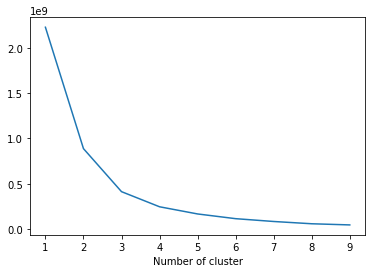

In [154]:
sse={}

for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(an_sales_sort_knn)
    an_sales_sort_knn["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [216]:
# k =4
kmeans = KMeans(n_clusters=4, max_iter=1000).fit(an_sales_sort_knn)
an_sales_sort_knn["clusters"] = kmeans.labels_
# k=4 is perfect cluster but cluster 1 is just one customer, we can put customer [0] to cluster 3. 
an_sales_sort_knn.iloc[0,3]=3

In [169]:
# adding total sales column
an_sales_sort_knn["try"]=an_sales_sort_knn["monetary"]*an_sales_sort_knn["frequency"]

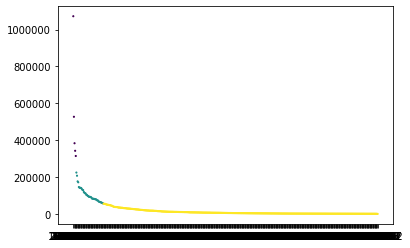

In [274]:
#scatterplot of clusters
plt.scatter(an_sales_sort["soldtocustomer"],an_sales_sort_knn["try"], c=an_sales_sort_knn["clusters"],
            s=5, cmap="viridis", marker=".")

##  CLUSTER 0 = HİGH VALUE, 1 = MİD VALUE, 2 = LOW VALUE


In [245]:
# Rearranging cluster numbers.
an_sales_sort_knn["clusters"][an_sales_sort_knn["clusters"]==3]=2


In [264]:
an_sales_sort_knn.groupby(["clusters"]).sum()

,recency,frequency,monetary,try
clusters,,,,
0,76,751,24961.756987,2636763.82
1,1691,3566,124091.897652,4544675.48
2,61550,5980,495824.681877,3859984.70


In [246]:
an_sales_sort_knn.groupby(["clusters"])["frequency"].describe()

,count,mean,std,min,25%,50%,75%,max
clusters,,,,,,,,
0,5.0,150.200000,88.587245,55.0,65.00,160.0,221.00,250.0
1,44.0,81.045455,65.256187,4.0,31.75,64.0,116.75,244.0
2,444.0,13.468468,21.911301,1.0,3.00,7.0,15.25,270.0


In [249]:
an_sales_sort_knn.groupby(["clusters"])["try"].describe()

,count,mean,std,min,25%,50%,75%,max
clusters,,,,,,,,
0,5.0,527352.764000,315252.202182,313687.45,341939.0300,382729.910,526455.6300,1071951.80
1,44.0,103288.079091,39324.102579,56837.83,76915.5475,91954.635,128552.7425,223801.42
2,444.0,8693.659234,11866.038421,-681.91,955.6600,3430.790,10810.4825,54372.76


In [260]:
# adding cluster info to sorted list.
an_sales_sort["clusters"]=an_sales_sort_knn["clusters"]

In [275]:
an_sales_sort.head(10)

,soldtocustomer,try,recency,frequency,monetary,clusters
0,16934334,1071951.80,17,160,6699.698750,0
1,26197972,526455.63,17,55,9571.920545,0
2,20980629,382729.91,14,65,5888.152462,0
3,21619938,341939.03,13,221,1547.235430,0
4,22609924,313687.45,15,250,1254.749800,0
5,16931802,223801.42,14,123,1819.523740,1
6,22552978,206591.08,27,52,3972.905385,1
7,16934149,175791.23,29,244,720.455861,1
8,22468865,170785.84,28,174,981.527816,1
9,24632659,145152.71,17,116,1251.316466,1


In [262]:
plt.scatter?

Signature:
plt.scatter(
    x,
    y,
    s=None,
    c=None,
    marker=None,
    cmap=None,
    norm=None,
    vmin=None,
    vmax=None,
    alpha=None,
    linewidths=None,
    verts=None,
    edgecolors=None,
    *,
    plotnonfinite=False,
    data=None,
    **kwargs,
)
Docstring:
A scatter plot of *y* vs *x* with varying marker size and/or color.

Parameters
----------
x, y : array_like, shape (n, )
    The data positions.

s : scalar or array_like, shape (n, ), optional
    The marker size in points**2.
    Default is ``rcParams['lines.markersize'] ** 2``.

c : color, sequence, or sequence of color, optional
    The marker color. Possible values:

    - A single color format string.
    - A sequence of color specifications of length n.
    - A sequence of n numbers to be mapped to colors using *cmap* and
      *norm*.
    - A 2-D array in which the rows are RGB or RGBA.

    Note that *c* should not be a single numeric RGB or RGBA sequence
    because that is indistinguishable f